### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 23rd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [2]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [2]:
# Load data
data = np.load('/Users/mcgowkb1/ASTR8070/repos/astr_8070_s24/coursework/homeworks/hw_data/hw6_data_1.npy')

X = data[:, :2]
labels = data[:, 2]

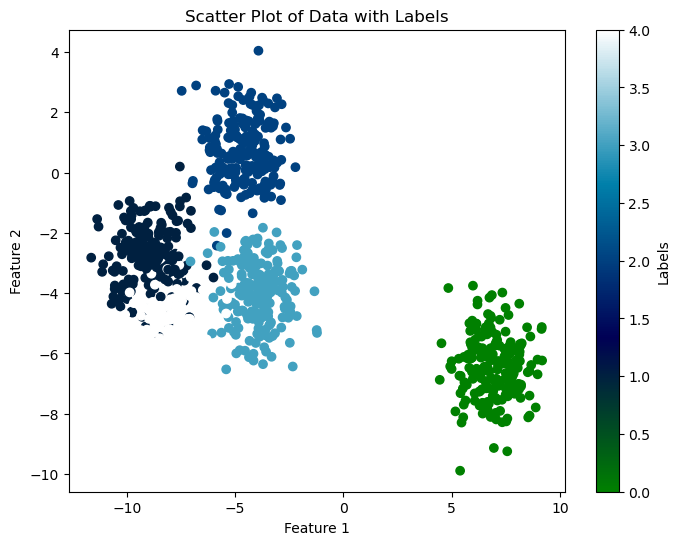

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='ocean')
plt.colorbar(label='Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Data with Labels')
plt.show()


SRT: Maybe not an optimal color scheme since there is one cluster of white points on a white background.

Best Bandwidth: 0.4724137931034482


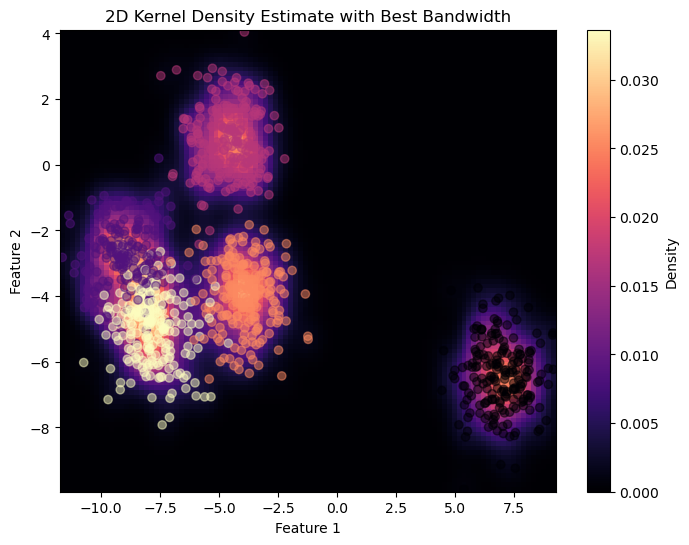

In [8]:
# Perform grid search for best bandwidth
bandwidths = np.linspace(0.1, 1.0, 30)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)
grid.fit(X)

# Find best bandwidth
best_bandwidth = grid.best_params_['bandwidth']
print("Best Bandwidth:", best_bandwidth)

# Plot the 2D kernel density estimate
kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth).fit(X)
x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
X_mesh, Y_mesh = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T
Z = np.exp(kde.score_samples(XY_mesh)).reshape(X_mesh.shape)

plt.figure(figsize=(8, 6))
plt.pcolormesh(X_mesh, Y_mesh, Z, cmap='magma')
plt.colorbar(label='Density')
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='magma', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Kernel Density Estimate with Best Bandwidth')
plt.show()


SRT: Nice

Best k neighbors: 4


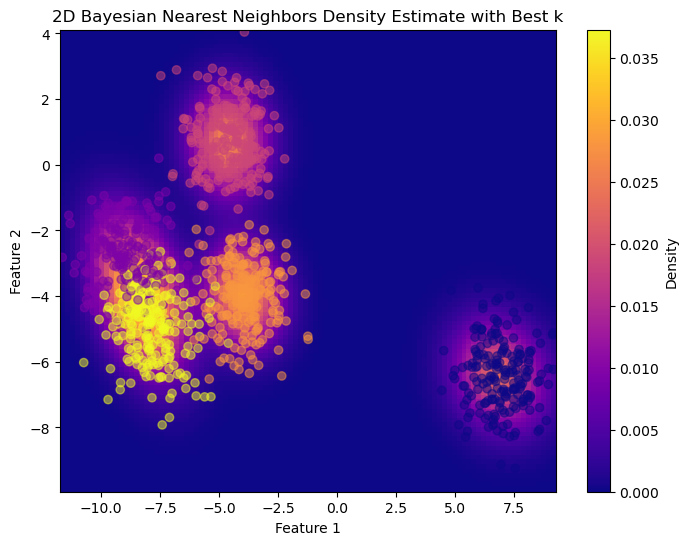

In [15]:
# Fit the Bayesian Gaussian Mixture model
k_values = range(1, 20)  # Trying different values of k neighbors
scores = []

for k in k_values:
    bgm = BayesianGaussianMixture(n_components=k, covariance_type='full', max_iter=1000, random_state=0)
    bgm.fit(X)
    scores.append(bgm.score(X))

best_k = k_values[np.argmax(scores)]
print("Best k neighbors:", best_k)

# Plot the est. distribution
bgm = BayesianGaussianMixture(n_components=best_k, covariance_type='full', max_iter=1000, random_state=0)
bgm.fit(X)

x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])

# Mesh for visual appeal
X_mesh, Y_mesh = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T
Z = np.exp(bgm.score_samples(XY_mesh)).reshape(X_mesh.shape)

plt.figure(figsize=(8, 6))
plt.pcolormesh(X_mesh, Y_mesh, Z, cmap='plasma')
plt.colorbar(label='Density')
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='plasma', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Bayesian Nearest Neighbors Density Estimate with Best k')
plt.show()


SRT: Oh no! I think you merged two parts of the question accidentally. Everything you did here was appropriate for finding the optimal number of Gaussian components in a GMM fitting. But there was a part of the question asking you to do KNN analysis too. -4 points.

In [16]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components & rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

Optimal number of components according to BIC: 4


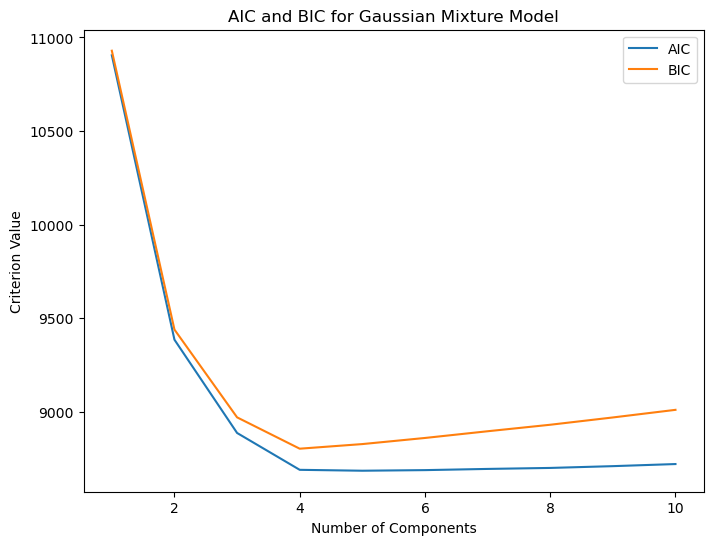

In [18]:
# Fit GMM w/ different numbers of components
n_components = np.arange(1, 11)
AIC = []
BIC = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(X)
    AIC.append(gmm.aic(X))
    BIC.append(gmm.bic(X))

# Find the optimal number of components based on BIC
optimal_n_components = n_components[np.argmin(BIC)]
print("Optimal number of components according to BIC:", optimal_n_components)

# Plot AIC and BIC values
plt.figure(figsize=(8, 6))
plt.plot(n_components, AIC, label='AIC')
plt.plot(n_components, BIC, label='BIC')
plt.xlabel('Number of Components')
plt.ylabel('Criterion Value')
plt.title('AIC and BIC for Gaussian Mixture Model')
plt.legend()
plt.show()


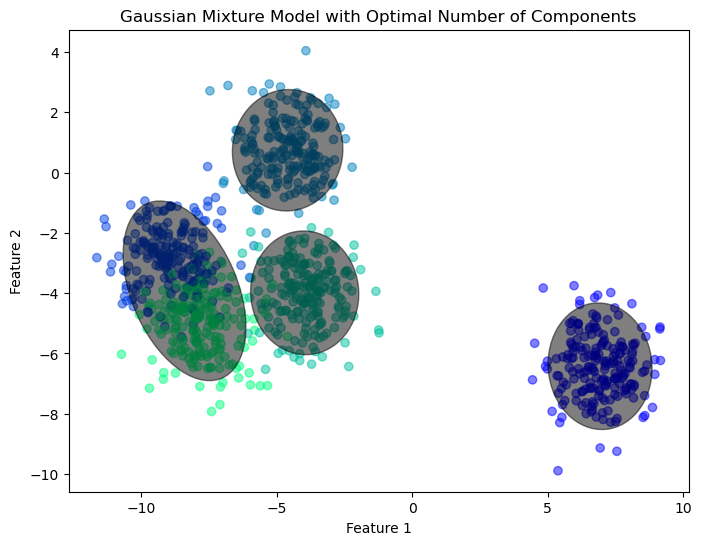

In [20]:
# Fit GMM w/ optimal number of components
gmm_optimal = GaussianMixture(n_components=optimal_n_components, random_state=0)
gmm_optimal.fit(X)

# Plot data set and GMM components
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='winter', alpha=0.5)

for i in range(optimal_n_components):
    draw_ellipse(gmm_optimal.means_[i], gmm_optimal.covariances_[i], scales=[2], alpha=0.5, color='k')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gaussian Mixture Model with Optimal Number of Components')
plt.show()


SRT: Excellent!

/Users/mcgowkb1/opt/anaconda3/envs/ASTR8070/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


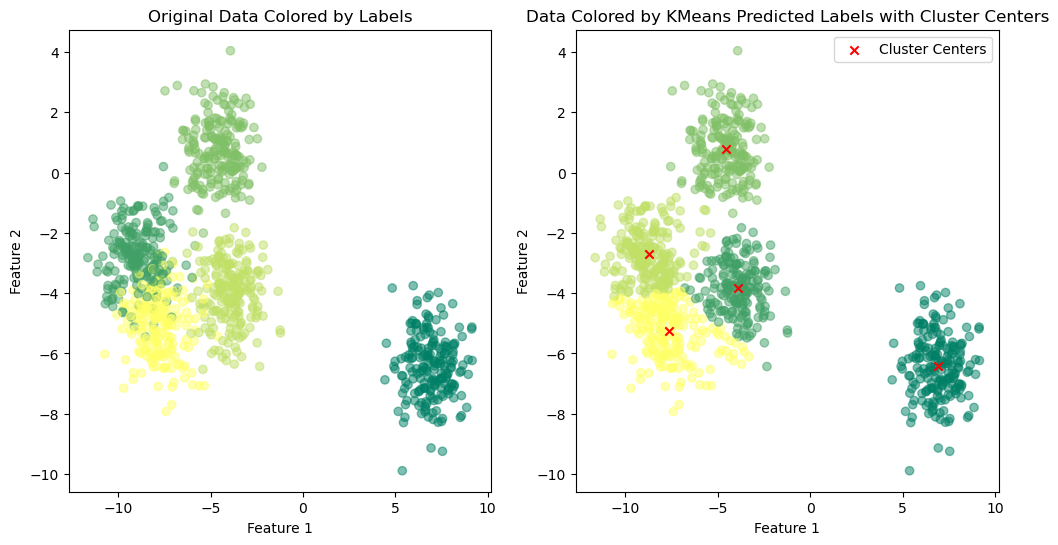

In [22]:
# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit KMeans model
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X_scaled)

# Inverse transform cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Predict labels for the scaled data
labels_kmeans = kmeans.predict(X_scaled)

# Plot original data colored by labels
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='summer', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Original Data Colored by Labels')

# Plot data colored by KMeans predicted labels with cluster centers
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels_kmeans, cmap='summer', alpha=0.5)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', c='r', label='Cluster Centers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Colored by KMeans Predicted Labels w/ Cluster Centers')
plt.legend()
plt.show()


SRT: Terrific work, Kaylah.